In [1]:
import os
if os.path.basename(os.getcwd())!="HUST-CV-Neural-Style-Transfer":
    %cd ../../

e:\pyenv\GTCC\KPG-RL\HUST-CV-Neural-Style-Transfer


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import torchvision.transforms.v2 as transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import math
import torchvision.models as models
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os

c:\Users\tungv\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.6 (you have 1.4.23). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
DATASET_PATH = "./datasets" 

Using device: cuda


In [4]:
class Failure(Dataset):
    def __init__(self, root_dir,true_length=50):
        super(Failure, self).__init__()
        self.root_dir = root_dir
        self.contents = os.listdir(os.path.join(self.root_dir,"contents"))[:true_length]
        self.contents.sort(key = lambda a: int(a.split("_")[1].split(".")[0]))
        self.styles = os.listdir(os.path.join(self.root_dir,"styles"))[:true_length]
        self.styles.sort(key = lambda a: int(a.split("_")[1].split(".")[0]))
    
    def get_pair_images(self,id_content,id_style):
        content_img = Image.open(os.path.join(self.root_dir,"contents",self.contents[id_content]))
        style_img = Image.open(os.path.join(self.root_dir,"styles",self.styles[id_style]))
                
        
        return content_img, style_img
    
    def get_pair_path(self,id_content,id_style):
        content_path = os.path.join(self.root_dir,"contents",self.contents[id_content])
        style_path = os.path.join(self.root_dir,"styles",self.styles[id_style])
                
        
        return content_path, style_path

In [5]:
from src.wct.model import MultiLevelAE_OST

In [6]:
# parameters to control style transfer

content_size_mult = 0.5 # multiplier for content image size
style_size_mult = 0.5  # multiplier for style image size, affects the size of style "brushes"
alpha = 1 # interpolation between original and transfered images (0 means keep original image)

# --- User-defined blending ratio ---
# 1.0 = 100% original content color, 0% stylized image "color" (which is monochrome)
# 0.0 = 0% original content color, 100% stylized image "color" (fully monochrome result)
# 0.7 = 70% original color, 30% stylized image "color" (partially desaturated)
color_retention_ratio = 1  # Adjust this value between 0.0 and 1.0

In [7]:
to_tensor_transforms = transforms.Compose([transforms.ToImage(),transforms.ToDtype(torch.float32,scale=True)])
to_img_transforms = transforms.ToPILImage()

def to_tensor(pil_img):
    img = to_tensor_transforms(pil_img).unsqueeze(0)
    return img

def to_img(tensor: torch.Tensor,content_img):
    tensor = tensor.cpu()
    tensor = tensor.clamp(0, 1).squeeze(0)
    img = to_img_transforms(tensor)
    size = content_img.size
    img = img.resize(size)
    return img 

def img_resize(image, rescale):
    return image.resize((int(image.size[0]*rescale), int(image.size[1]*rescale)))

def color_injection(c_path,output):
    content_img_bgr = cv2.imread(c_path)
    stylized_numpy_array = np.array(output)
    content_img_ycrcb = cv2.cvtColor(content_img_bgr, cv2.COLOR_BGR2YCrCb)
    stylized_img_ycrcb = cv2.cvtColor(stylized_numpy_array, cv2.COLOR_RGB2YCrCb)
    content_y, content_cr, content_cb = cv2.split(content_img_ycrcb)
    stylized_y_from_styled, stylized_cr_from_styled, stylized_cb_from_styled = cv2.split(stylized_img_ycrcb)
    
    final_luminance = stylized_y_from_styled # This is the Y channel from the BGR stylized image

    content_cr_float = content_cr.astype(np.float32)
    content_cb_float = content_cb.astype(np.float32)
    stylized_cr_float = stylized_cr_from_styled.astype(np.float32) # From the (mono)stylized image
    stylized_cb_float = stylized_cb_from_styled.astype(np.float32) # From the (mono)stylized image

    blended_cr_float = (color_retention_ratio * content_cr_float +
                        (1 - color_retention_ratio) * stylized_cr_float)
    blended_cb_float = (color_retention_ratio * content_cb_float +
                        (1 - color_retention_ratio) * stylized_cb_float)

    blended_cr = np.clip(blended_cr_float, 0, 255).astype(np.uint8)
    blended_cb = np.clip(blended_cb_float, 0, 255).astype(np.uint8)

    # --- 6. Combine Final Luminance with Blended Chrominance ---
    final_ycrcb_blended = cv2.merge([final_luminance, blended_cr, blended_cb])

    # --- 7. Convert Back to BGR ---
    final_color_blended_bgr = cv2.cvtColor(final_ycrcb_blended, cv2.COLOR_YCrCb2BGR)
    
    final_img_rgb = cv2.cvtColor(final_color_blended_bgr, cv2.COLOR_BGR2RGB)
    
    final_img_pil = Image.fromarray(final_img_rgb)
    return final_img_pil

In [8]:
model = MultiLevelAE_OST(pretrained_path_dir='./models/wct').to(DEVICE)

e:\pyenv\GTCC\KPG-RL\HUST-CV-Neural-Style-Transfer\src\wct\model.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(pretrained_path, ma

In [9]:
dataset = Failure(DATASET_PATH)

  0%|          | 0/2500 [00:00<?, ?it/s]

KeyboardInterrupt: 

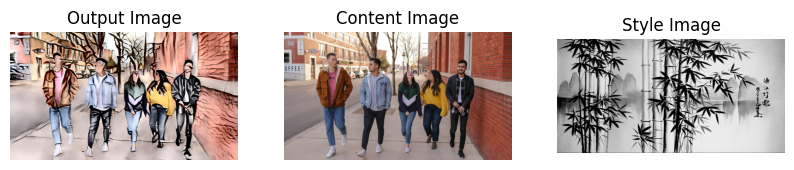

In [11]:
for i,k in tqdm([(i,k) for i in range(50) for k in range(50)]):
    c,s = dataset.get_pair_images(i,k)
    c = c.convert("RGB")
    s = s.convert("RGB")
    c_path,_ = dataset.get_pair_path(i,k)
    with torch.no_grad():
        content = img_resize(c, content_size_mult)
        style = img_resize(s, style_size_mult)
        
        content = to_tensor(content).to(DEVICE)
        style = to_tensor(style).to(DEVICE)
        output = model(content, style, alpha=alpha)
        output = to_img(output,c)
        
    final_img_pil = color_injection(c_path,output)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(final_img_pil)
    plt.axis('off')
    plt.title("Output Image")
    plt.subplot(1, 3, 2)
    plt.imshow(c)
    plt.axis('off')
    plt.title("Content Image")
    plt.subplot(1, 3, 3)
    plt.imshow(s)
    plt.axis('off')
    plt.title("Style Image")
    plt.savefig(f"outputs/comparision_{i}_{k}.png")
    final_img_pil.save(f"outputs/final_img_{i}_{k}.png")